# Testing Tight Divergence on MNIST

In [1]:
import sys
sys.path.append("..")

In [2]:
## Enable/Disable Titles
show_titles = False

## Train a MLP on MNIST

In [3]:
import perceptrons.mnist as mnist

mnist_mlp = mnist.MNIST(
    [784, 32, 10],     # Architecture
    6,                      # Num. of Epochs
    128,                     # Batch Size
    "MNIST-mlp"             # MLP name
)

Epoch 1/6
375/375 [==============================] - 8s 21ms/step - loss: 1.3236 - accuracy: 0.6933 - val_loss: 0.8495 - val_accuracy: 0.8808
Epoch 2/6
375/375 [==============================] - 4s 11ms/step - loss: 0.8237 - accuracy: 0.8817 - val_loss: 0.7827 - val_accuracy: 0.8994
Epoch 3/6
375/375 [==============================] - 6s 15ms/step - loss: 0.8066 - accuracy: 0.8864 - val_loss: 0.8434 - val_accuracy: 0.8563
Epoch 4/6
375/375 [==============================] - 6s 15ms/step - loss: 0.8153 - accuracy: 0.8846 - val_loss: 0.7712 - val_accuracy: 0.9029
Epoch 5/6
375/375 [==============================] - 3s 8ms/step - loss: 0.7922 - accuracy: 0.8917 - val_loss: 0.7813 - val_accuracy: 0.8947
Epoch 6/6
375/375 [==============================] - 4s 10ms/step - loss: 0.8061 - accuracy: 0.8850 - val_loss: 0.7593 - val_accuracy: 0.9030


In [4]:
mnist_mlp.report()

~~ Reporting ~~
Parameters:
_________________________________________________________________
    Name:              MNIST-mlp
    In. Shape.:        (28, 28)
    Out Dim.:          10
    Architercture:     ListWrapper([784, 32, 10])
    Init.:             Training
    Activ. Func.:      ReLU
Layers:
_________________________________________________________________
    Name        In. Shape        Out. Shape          Weight Shape                  
    flatten     (28, 28)         (784,)              []                            
    dense_0     (784,)           (32,)               (784, 32)                     
    dense_1     (32,)            (10,)               (32, 10)                      
Metrics:
_________________________________________________________________
    Train Loss:        0.7761
    Train Accuracy:    0.8973
    Test Loss:         0.7669
    Test Accuracy:     0.8995





## Pre-Processing

In [5]:
import numpy as np
import geometry.interval as interval
import geometry.circle as circle
import matplotlib.pyplot as plt

InputDomain = interval.Interval(
    np.zeros(mnist_mlp.in_shape),
    np.ones(mnist_mlp.in_shape)
)

### Generate Inputs for each Class

In [6]:
## Get random points
N                   = 1000
RandomTestInputs    = mnist_mlp.random_points(N)

Inputs_per_class = []
for c in range(10):
    input_c = None
    ind     = 0
    while (input_c is None) and (ind <= N-1):
        input = RandomTestInputs[ind]
        if mnist_mlp.predict(input) == c:
            input_c = input
        ind += 1

    if input_c is not None:
        Inputs_per_class.append(input_c)
        input_c = None
    else:
        print("Error: Did not find input for class", c)

## Metrics

In [7]:
## tight divergence
def avg_tight_divergence(relu_scores, conv_scores):
    tight_divergence        = np.max(np.abs(relu_scores - conv_scores), 0)
    avg_tight_divergence    = np.sum(tight_divergence) / len(tight_divergence)

    return avg_tight_divergence

## misclassification
def misclassification_prob(relu_preds, conv_preds):
    misclassifications      = np.array(relu_preds) != np.array(conv_preds)
    misclassification_prob  = np.sum(misclassifications) / len(misclassifications)

    return misclassification_prob

## Increasing Radius per Class

###  Average Tight Divergence

#### Experiment

In [8]:
import perceptrons.convex as convex

In [9]:
N = 10_000

avg_tight_divergence_per_class = []

for c in range(10):

    avg_tight_divergence_per_radius = []
    for rad in np.arange(0, 1.1, 0.1):
        ## Create Vicinity
        center      = Inputs_per_class[c]
        vicinity    = circle.InfCircle(center, rad).get_interval() & InputDomain

        ## Generate Inputs
        RandomInputs = vicinity.random_points(N)

        ## Generate Tight Conv. Approx. for Vicinity
        conv_approx = convex.ConvexApprox(
                        mnist_mlp,
                        vicinity
                    )
        
        ## Calculate Scores
        relu_scores = mnist_mlp.scores(RandomInputs)
        conv_scores = conv_approx.scores(RandomInputs)

        ## Calculate Metrics
        atd = avg_tight_divergence(relu_scores, conv_scores)
        avg_tight_divergence_per_radius.append(atd)
    
    avg_tight_divergence_per_class.append(avg_tight_divergence_per_radius)


print(avg_tight_divergence_per_class)
        

[[0.0, 0.7658174514770508, 2.4658931732177733, 3.9054916381835936, 5.424670791625976, 6.863348388671875, 8.156297302246093, 9.350179290771484, 10.501710510253906, 11.57698745727539, 12.5255615234375], [0.0, 1.104156494140625, 2.8186100006103514, 4.424623489379883, 5.798614501953125, 7.089281463623047, 8.281278991699219, 9.41746826171875, 10.51412353515625, 11.550115203857422, 12.5255615234375], [0.0, 0.6248515129089356, 2.322914886474609, 3.8766410827636717, 5.426279449462891, 6.745954895019532, 8.034117889404296, 9.292506408691406, 10.46042709350586, 11.55051040649414, 12.5255615234375], [0.0, 1.4453330993652345, 3.1115900039672852, 4.504963302612305, 5.818587112426758, 7.06368408203125, 8.27624282836914, 9.435604858398438, 10.532817077636718, 11.560202026367188, 12.5255615234375], [0.0, 1.1710783958435058, 2.9388864517211912, 4.571127319335938, 6.010286712646485, 7.339442443847656, 8.551988983154297, 9.656629943847657, 10.677183532714844, 11.644491577148438, 12.5255615234375], [0.0, 

#### Visualization

In [10]:
import matplotlib.colors as mcolors
colors_per_class = list(mcolors.TABLEAU_COLORS.keys())

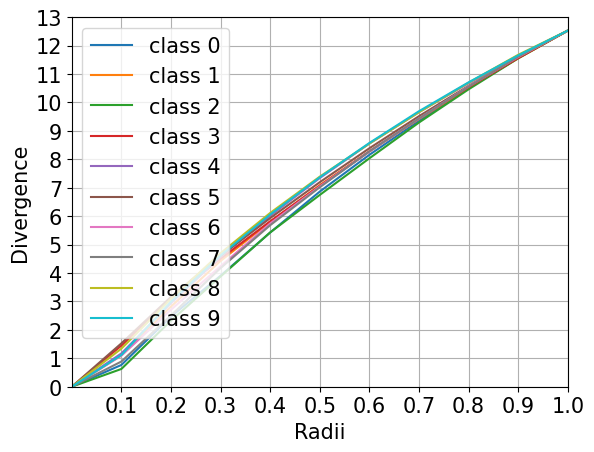

In [17]:
## log plots
plt.rcParams.update({'font.size': 15})
ax = plt.axes()



radii = np.arange(0, 1.1, 0.1)
for c in range(10):
    plt.plot(
        radii,
        avg_tight_divergence_per_class[c],
        label="class " + str(c),
        linestyle = "-",
        color = colors_per_class[c]
    )

plt.legend()
plt.grid(True)
if show_titles: plt.title("Average Tight Divergence\n w.r.t. Increasing Radii")
plt.ylabel("Divergence")
plt.xlabel("Radii")

plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0, 14))
ax.set(xlim=(0, 1), ylim=(0, 13))
plt.show()

### Counting Misclassifications

#### Experiment

In [ ]:
N = 10_000

missclassification_prob_per_class = []

for c in range(10):

    missclassification_prob_per_radius = []
    for rad in np.arange(0, 1.1, 0.1):
        ## Create Vicinity
        center      = Inputs_per_class[c]
        vicinity    = circle.InfCircle(center, rad).get_interval() & InputDomain

        ## Generate Inputs
        RandomInputs = vicinity.random_points(N)

        ## Generate Tight Conv. Approx. for Vicinity
        conv_approx = convex.ConvexApprox(
                        mnist_mlp,
                        vicinity
                    )
        
        ## Calculate Scores
        relu_preds = mnist_mlp.predict(RandomInputs)
        conv_preds = conv_approx.predict(RandomInputs)

        ## Calculate Metrics
        mcp = misclassification_prob(relu_preds, conv_preds)
        missclassification_prob_per_radius.append(mcp)
    
    missclassification_prob_per_class.append(missclassification_prob_per_radius)


#print(missclassification_prob_per_class)

[[0.0, 0.0, 0.0, 0.0002, 0.5341, 0.9995, 1.0, 1.0, 1.0, 0.9994, 0.9945], [0.0, 0.0, 0.0, 0.9095, 1.0, 0.9972, 0.9651, 0.9001, 0.917, 0.9728, 0.9945], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0128, 0.3691, 0.9032, 0.9945], [0.0, 0.0037, 0.8062, 0.9773, 0.9842, 0.9278, 0.8646, 0.8971, 0.9509, 0.9828, 0.9945], [0.0, 0.0, 0.0, 0.0, 0.0357, 0.4292, 0.7117, 0.8564, 0.9512, 0.9845, 0.9945], [0.0, 0.0, 0.0, 0.0011, 0.0943, 0.6998, 0.9636, 0.9908, 0.992, 0.9927, 0.9945], [0.0, 0.0, 0.0, 0.0, 0.0184, 0.6561, 0.8717, 0.5234, 0.7032, 0.9471, 0.9945], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0007, 0.2218, 0.8747, 0.9817, 0.99, 0.9945], [0.0, 0.0, 0.0002, 0.1764, 0.8467, 0.9942, 0.9768, 0.9673, 0.9847, 0.9927, 0.9945], [0.0, 0.0, 0.4741, 0.9999, 0.9977, 0.9301, 0.8127, 0.8632, 0.9679, 0.9931, 0.9945]]


#### Visualization

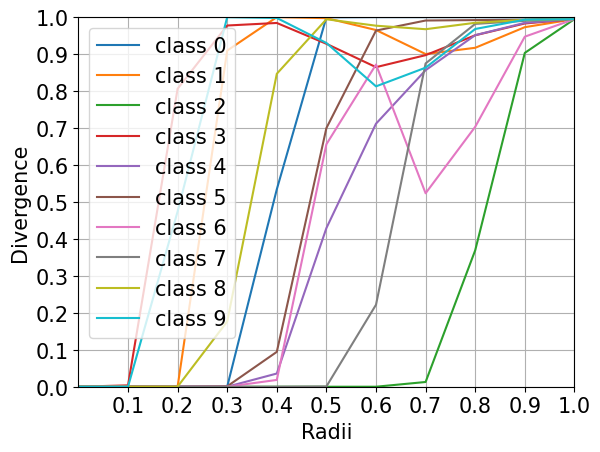

In [16]:
## log plots
plt.rcParams.update({'font.size': 15})
ax = plt.axes()



radii = np.arange(0, 1.1, 0.1)
for c in range(10):
    plt.plot(
        radii,
        missclassification_prob_per_class[c],
        label="class " + str(c),
        linestyle = "-",
        color = colors_per_class[c]
    )

plt.legend()
plt.grid(True)
if show_titles: plt.title("Misclassification Probability\n w.r.t. Increasing Radii")
plt.ylabel("Divergence")
plt.xlabel("Radii")

plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set(xlim=(0, 1), ylim=(0, 1))
plt.show()